In [89]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm

from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG


from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

In [90]:
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
start = '2005-01-01'
current_date = (date.today()).strftime('%Y-%m-%d')

# Calculate S Score

In [93]:
factor_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
risk_free = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')

# Read in live market data
sector_df = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=current_date)
T = [1]
sector_df = sector_df[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_df = sector_df.rename(columns={'Adj Close': 'Close'})

sector_df = create_return(sector_df, T)
sector_df = sector_df.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_df = sector_df.unstack('ticker').swaplevel(axis=1)
sector_df.columns = ['_'.join(col).strip() for col in sector_df.columns.values]

sector_data = sector_df
sector_data = pd.concat([sector_data, risk_free['RF']], axis=1)
sector_data = sector_data.loc[start:current_date]
sector_data = sector_data.fillna(0)
factor_col = sector_data.columns[:-1]

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.30s/ticker]


In [94]:
# Assuming `data` is your DataFrame with multi-index (permno, date), and columns 'Volume' and 'close'
# Calculate cumulative volume for each stock
factor_data['cumulative_volume'] = factor_data.groupby('permno')['Volume'].cumsum()
# Compute the difference in closing prices (not percentage returns)
factor_data['price_diff'] = factor_data.groupby('permno')['Close'].diff()
# Compute the volume difference
factor_data['volume_diff'] = factor_data.groupby('permno')['cumulative_volume'].diff()
# Calculate the average trading volume over the past 21 trading days
factor_data['avg_volume'] = factor_data.groupby('permno')['Volume'].rolling(window=21).mean().reset_index(level=0, drop=True)
# Compute the modified returns
factor_data['RET_01_ADJ'] = (factor_data['price_diff'] / factor_data['Close']) * (factor_data['avg_volume'] / factor_data['volume_diff'])

In [95]:
T = [1]
factor_data = create_return(factor_data, T)

In [96]:
factor_data = factor_data.fillna(0)

In [97]:
for t in T:
    ret = f'RET_01_ADJ'
    # if window size is too big it can create an index out of bound error (took me 3 hours to debug this error!!!)
    window = 21
    etf = rolling_ols_parallel(data=factor_data, ret=ret, factor_data=sector_data, factor_cols=factor_col.tolist(), window=window, name=f'sector_{t:02}')

In [98]:
etf.columns

Index(['ALPHA_sector_01_21', 'XLB_RET_01_sector_01_21',
       'XLE_RET_01_sector_01_21', 'XLF_RET_01_sector_01_21',
       'XLI_RET_01_sector_01_21', 'XLK_RET_01_sector_01_21',
       'XLP_RET_01_sector_01_21', 'XLU_RET_01_sector_01_21',
       'XLV_RET_01_sector_01_21', 'XLY_RET_01_sector_01_21',
       'epsil_sector_01_21', 'pred_sector_01_21', 'resid_mom_21_sector_01_21',
       'resid_mom_126_sector_01_21', 'idio_vol_21_sector_01_21',
       'idio_vol_126_sector_01_21'],
      dtype='object')

In [99]:
etf_short = etf[etf.columns[1:11]]

In [100]:
etf_short['Xk'] = etf_short['epsil_sector_01_21'].rolling(21).sum()
etf_short['Xk_lag'] = etf_short['Xk'].groupby('permno').shift(-1)
etf_short['Xk_diff'] = etf_short['Xk'].groupby('permno').diff()
etf_short = etf_short.fillna(0)

In [101]:
def process_stock(stock_data, ret, factor_col, window, stock_name, index_name):
    model_data = stock_data[[ret, factor_col]].dropna()
    rolling_ols = RollingOLS(endog=model_data[ret], exog=sm.add_constant(model_data[factor_col]), window=window)
    factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})
    result = factor_model.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    return result

def compute_betas_parallel(etf, ret='Xk_diff', factor_col='Xk_lag', window=21, name='ss'):
    tasks = [(group, ret, factor_col, window, stock, etf.index.names[0]) for stock, group in etf.groupby(etf.index.names[0])]
    results = Parallel(n_jobs=-1)(delayed(process_stock)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

betas = compute_betas_parallel(etf_short).droplevel(0)

In [102]:
betas.columns

Index(['ALPHA_ss_21', 'Xk_lag_ss_21'], dtype='object')

In [103]:
group = betas.copy(deep=True)
group.columns = ['a', 'b']
group = group.merge(etf_short[['Xk_diff', 'Xk_lag']], left_index=True, right_index=True, how='left')

In [104]:
group['kappa'] = -np.log(group['b']) * 252
group['m'] = group['a'] / (1 - group['b'])
group['sigma'] = np.sqrt(group['Xk_diff'].var() * 2 * group['kappa'] / (1 - group['b']**2))
group['sigma_eq'] = np.sqrt(group['Xk_diff'].var() / (1 - group['b']**2))
group['s_score'] = -group['m'] / group['sigma_eq']

mean_a = group['a'].mean()
group['m'] = mean_a / (1 - group['b'])
group['s_score_centered'] = (-group['a'] * np.sqrt(1 - group['b']**2) / (1 - group['b']) * np.sqrt(group['Xk_diff'].var()) + mean_a / (1 - group['b']) * np.sqrt(group['Xk_diff'].var())) / group['sigma_eq']

# Backtest

In [105]:
# Read in live market data
sector_df = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=current_date)
T = [1]
sector_df = sector_df[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_df = sector_df.rename(columns={'Adj Close': 'Close'})

sector_df = create_return(sector_df, T)
sector_df = sector_df.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_df = sector_df.unstack('ticker').swaplevel(axis=1)
sector_df.columns = ['_'.join(col).strip() for col in sector_df.columns.values]

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.48s/ticker]


In [106]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

sector_multi = create_multi_index(sector_df, stock)

In [107]:
combined = group[['s_score']].merge(etf_short, left_index=True, right_index=True, how='left')
combined = combined.merge(sector_multi, left_index=True, right_index=True, how='left')
combined = combined.merge(factor_data[['RET_01']], left_index=True, right_index=True, how='left')

In [108]:
combined = combined.dropna()

In [109]:
combined.columns

Index(['s_score', 'XLB_RET_01_sector_01_21', 'XLE_RET_01_sector_01_21',
       'XLF_RET_01_sector_01_21', 'XLI_RET_01_sector_01_21',
       'XLK_RET_01_sector_01_21', 'XLP_RET_01_sector_01_21',
       'XLU_RET_01_sector_01_21', 'XLV_RET_01_sector_01_21',
       'XLY_RET_01_sector_01_21', 'epsil_sector_01_21', 'Xk', 'Xk_lag',
       'Xk_diff', 'XLB_RET_01', 'XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01',
       'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01',
       'RET_01'],
      dtype='object')

In [110]:
combined = combined[['s_score', 'RET_01', 'XLB_RET_01_sector_01_21', 'XLE_RET_01_sector_01_21', 
                     'XLP_RET_01_sector_01_21', 'XLU_RET_01_sector_01_21', 'XLV_RET_01_sector_01_21', 
                     'XLY_RET_01_sector_01_21', 'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
                     'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']]

In [111]:
def compute_trading_signal(data, sbo, sso, sbc, ssc):
    def apply_rules(group):
        position = None
        signals = []

        for s_score in group['s_score']:
            if position is None:
                if s_score < -sbo:
                    position = 'buy'
                    signals.append('buy to open')
                elif s_score > sso:
                    position = 'sell'
                    signals.append('sell to open')
                else:
                    signals.append(None)
            elif position == 'buy':
                if s_score > -ssc:
                    position = None
                    signals.append('close long')
                else:
                    signals.append('hold')
            elif position == 'sell':
                if s_score < sbc:
                    position = None
                    signals.append('close short')
                else:
                    signals.append('hold')
            else:
                signals.append(None)

        return pd.Series(signals, index=group.index)

    # Sort data by permno and date for consistency
    data = data.sort_values(by=['permno', 'date'])
    # Group by permno and apply the rules for each group
    data['signal'] = data.groupby('permno').apply(lambda x: apply_rules(x)).reset_index(level=0, drop=True)
    return data

In [144]:
sbo = 0
sso = -0.15
sbc = 0.15
ssc = 0.10
result = compute_trading_signal(combined, sbo, sso, sbc, ssc)

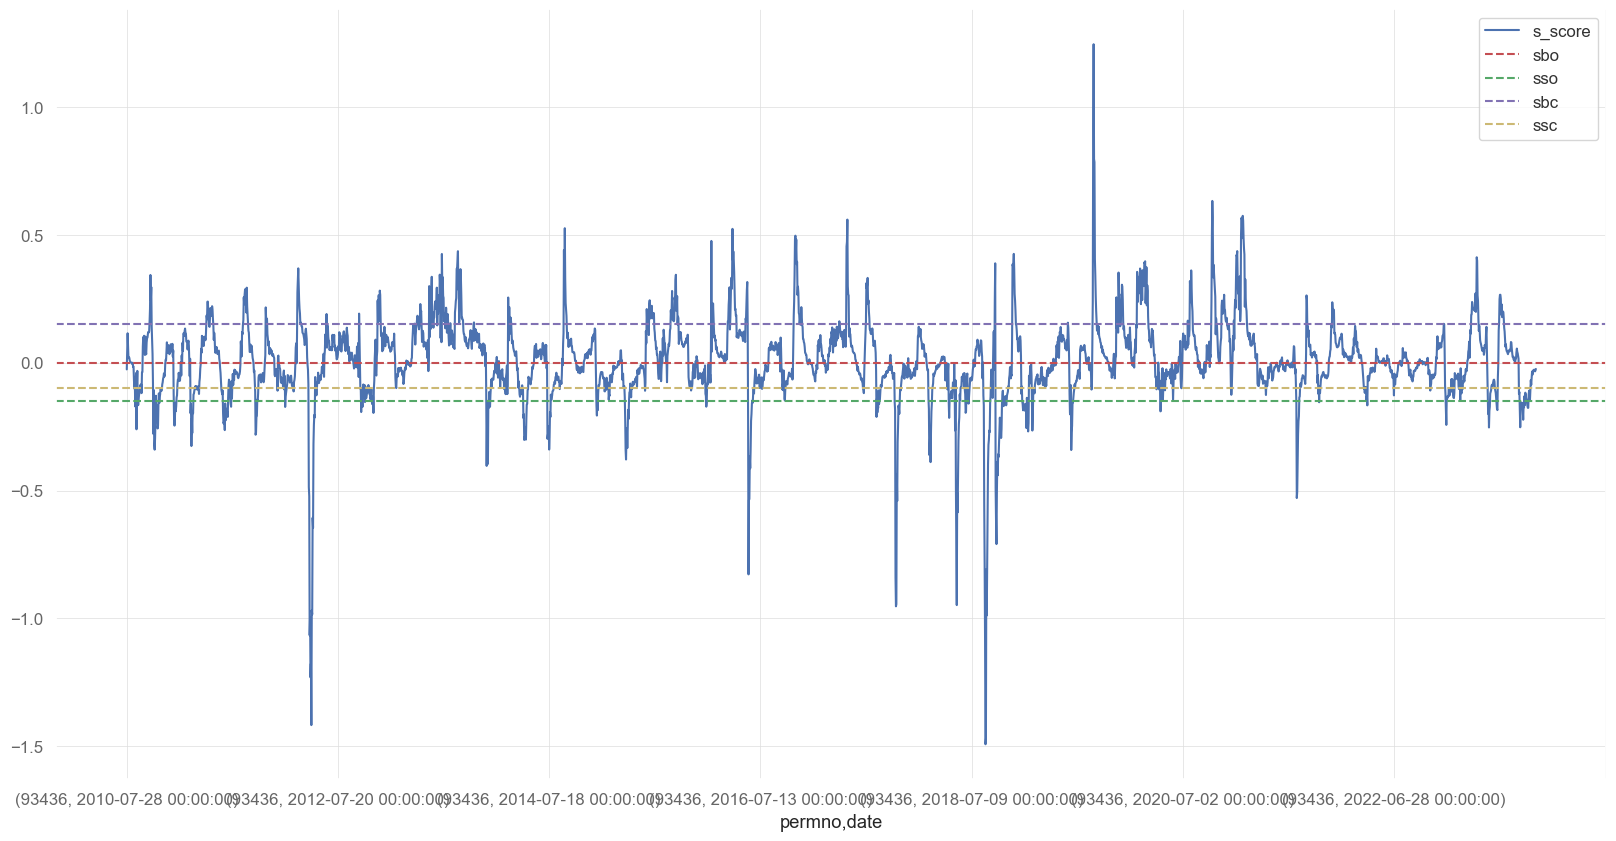

In [145]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the s_score
get_stock_data(combined, 93436).s_score.plot(ax=ax)
# Plot the threshold lines
ax.axhline(y=-sbo, color='r', linestyle='--', label='sbo')
ax.axhline(y=sso, color='g', linestyle='--', label='sso')
ax.axhline(y=sbc, color='m', linestyle='--', label='sbc')
ax.axhline(y=-ssc, color='y', linestyle='--', label='ssc')
# Add legend
ax.legend()
# Display the plot
plt.show()

In [146]:
def compute_portfolio_returns(df):
    # Map signal to its corresponding position
    position_map = {
        'buy to open': 'long',
        'sell to open': 'short',
        'close long': 'close long',
        'close short': 'close short'
    }
    
    # Create a 'position' column based on 'signal' column
    df['position'] = df['signal'].map(position_map)
    
    # Forward fill the long/short positions until a close signal
    df['position'] = df['position'].where(df['position'].str.contains('close'), df['position'].ffill())
    
    # Extract all beta columns and compute the cumulative hedge return
    beta_columns = [col for col in df.columns if '_sector_' in col]
    hedge_return = sum(df[beta] * df[beta.split('_sector_')[0].replace('_sector_', '')] for beta in beta_columns)

    # Create conditions
    long_condition = df['position'] == 'long'
    short_condition = df['position'] == 'short'
    close_long_condition = df['position'] == 'close long'
    close_short_condition = df['position'] == 'close short'
    
    # Compute portfolio returns
    df['portfolio_return'] = np.where(long_condition, df['RET_01'] - hedge_return, 
                                      np.where(short_condition, -df['RET_01'] + hedge_return, 
                                               np.where(close_long_condition, df['RET_01'] - hedge_return, 
                                                        np.where(close_short_condition, -df['RET_01'] + hedge_return, 0))))

    # Clean up the helper column
    df.drop('position', axis=1, inplace=True)
    return df['portfolio_return']

In [147]:
result['portfolio_return'] = result.groupby(level=0).apply(compute_portfolio_returns).reset_index(level=0, drop=True)

In [148]:
def validate_signals(signals):
    buy_to_open_count = signals[signals == 'buy to open'].count()
    close_long_count = signals[signals == 'close long'].count()
    sell_to_open_count = signals[signals == 'sell to open'].count()
    close_short_count = signals[signals == 'close short'].count()
    if buy_to_open_count != close_long_count:
        return f"Buy to Open: {buy_to_open_count}, Close Long: {close_long_count}"
    if sell_to_open_count != close_short_count:
        return f"Sell to Open: {sell_to_open_count}, Close Short: {close_short_count}"
    return "Balanced"

In [149]:
signal_counts = result.groupby(level=0)['signal'].apply(validate_signals)
imbalanced_signals = signal_counts[signal_counts != "Balanced"]
print(imbalanced_signals)

permno
10104    Sell to Open: 1149, Close Short: 1148
10107        Buy to Open: 999, Close Long: 998
10137      Sell to Open: 364, Close Short: 363
10147      Sell to Open: 612, Close Short: 611
10225        Buy to Open: 541, Close Long: 540
                         ...                  
93096        Buy to Open: 653, Close Long: 652
93101        Buy to Open: 689, Close Long: 688
93150        Buy to Open: 710, Close Long: 709
93159        Buy to Open: 362, Close Long: 361
93384        Buy to Open: 404, Close Long: 403
Name: signal, Length: 539, dtype: object


In [150]:
# Create a mask for active investments
active_investments = result['portfolio_return'] != 0
# Use the mask to filter the DataFrame and then group by date to calculate the mean return
ewp_return = result[active_investments].groupby(level=1)['portfolio_return'].mean()

## Plot

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-02   2005-02-02
End Period                 2023-10-27   2023-10-27
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          245.37%      217.35%
CAGR﹪                     4.67%        4.35%

Sharpe                     0.44         0.98
Prob. Sharpe Ratio         97.06%       100.0%
Smart Sharpe               0.43         0.95
Sortino                    0.61         1.43
Smart Sortino              0.6          1.39
Sortino/√2                 0.43         1.01
Smart Sortino/√2           0.42         0.98
Omega                      1.28         1.28

Max Drawdown               -56.47%      -23.51%
Longest DD Days            1982         1497
Volatility (ann.)          19.45%       6.5%
R^2                        0.01         0.01
Information Ratio          -0.01        -0.01
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-09-28,2017-10-18,2021-11-02,1497,-23.509639,-16.248819
2,2022-07-15,2023-04-06,2023-10-27,470,-8.359612,-7.198152
3,2011-07-08,2011-08-19,2011-10-21,106,-7.742117,-7.570442
4,2016-04-26,2016-06-27,2016-06-29,65,-6.449936,-4.455855
5,2008-10-10,2008-10-27,2008-11-03,25,-4.566088,-4.513482


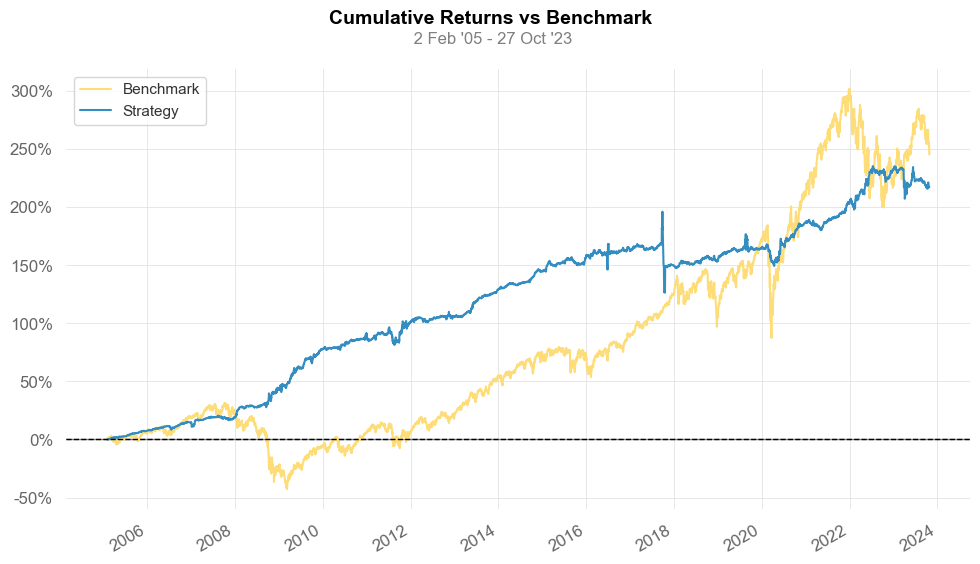

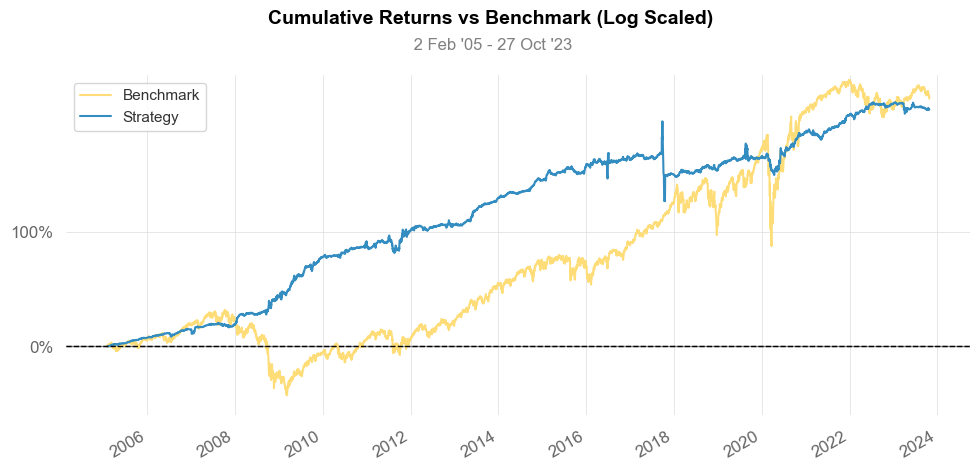

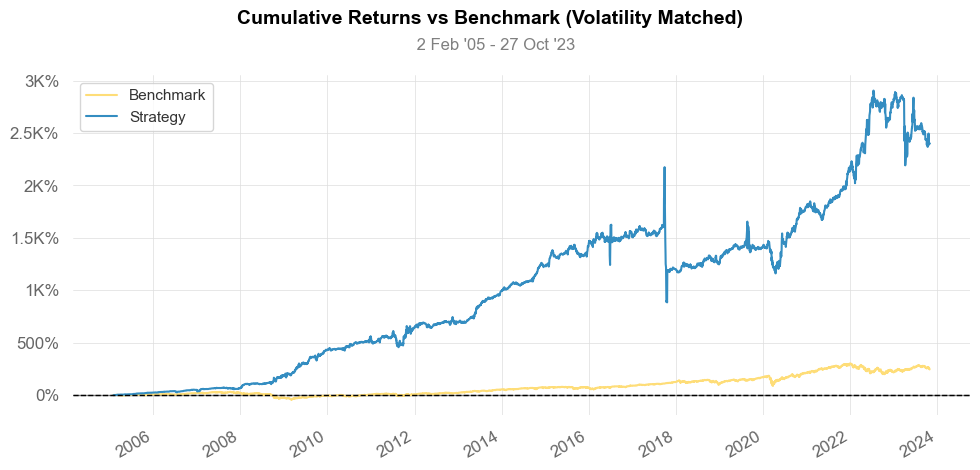

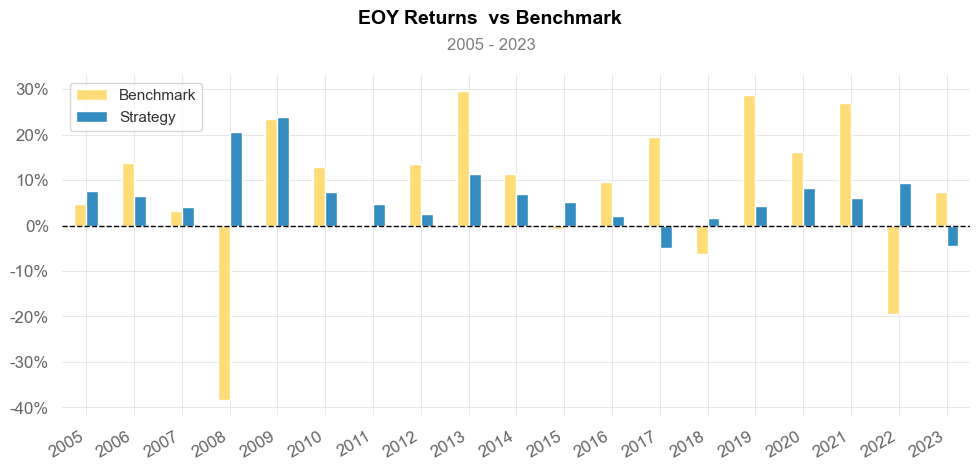

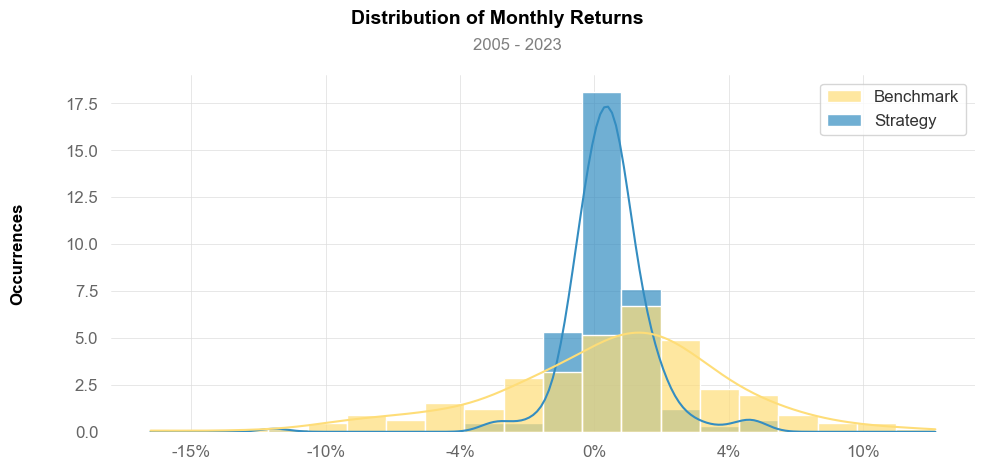

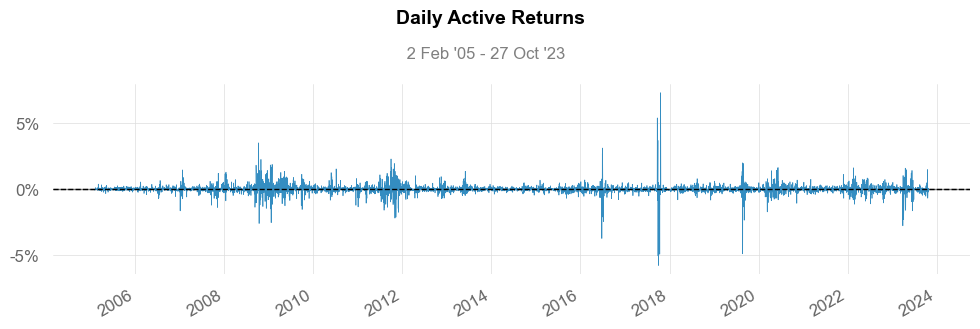

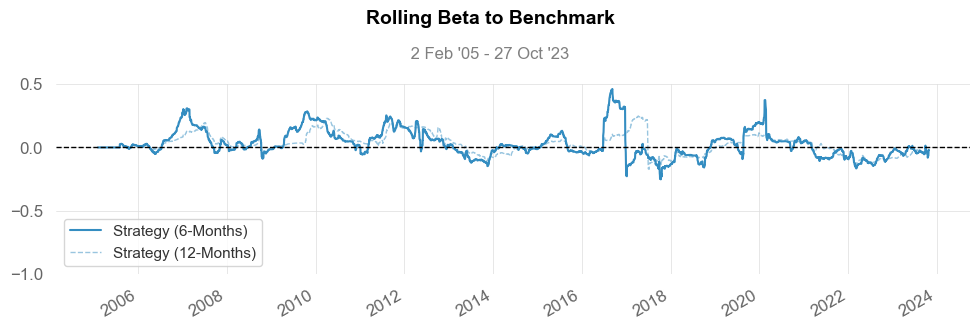

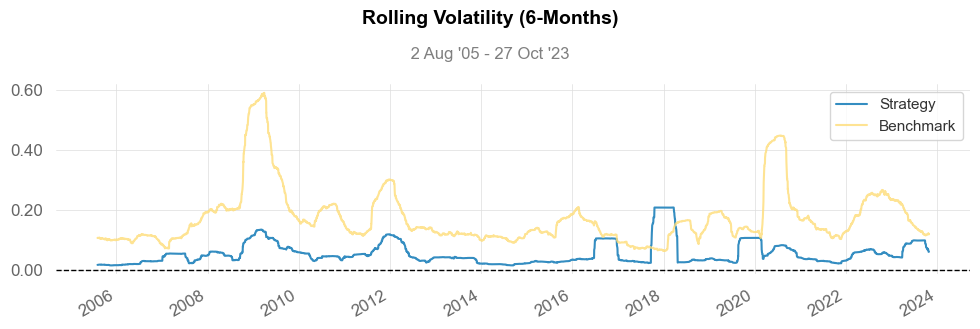

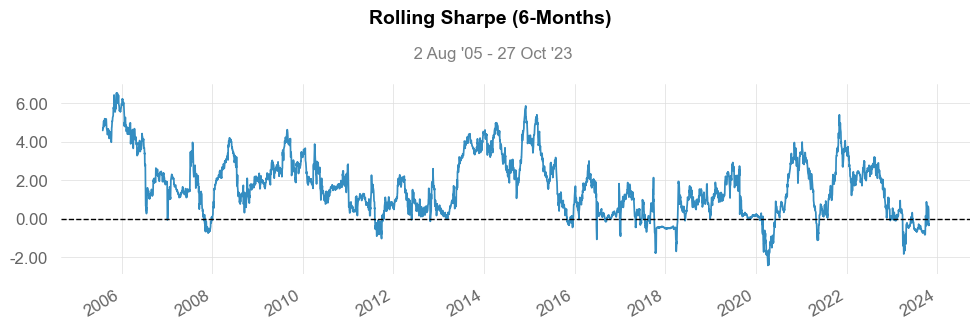

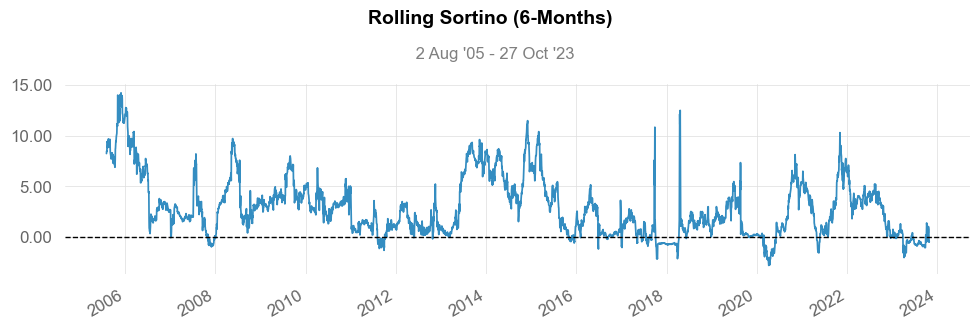

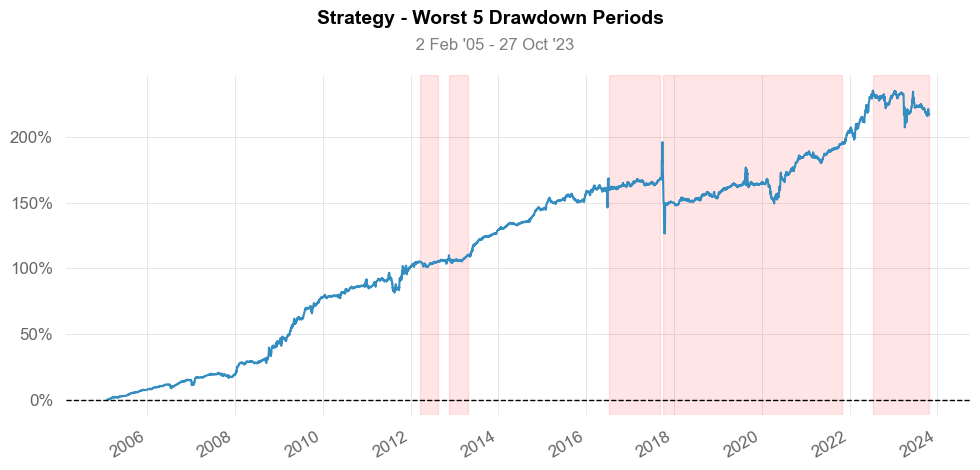

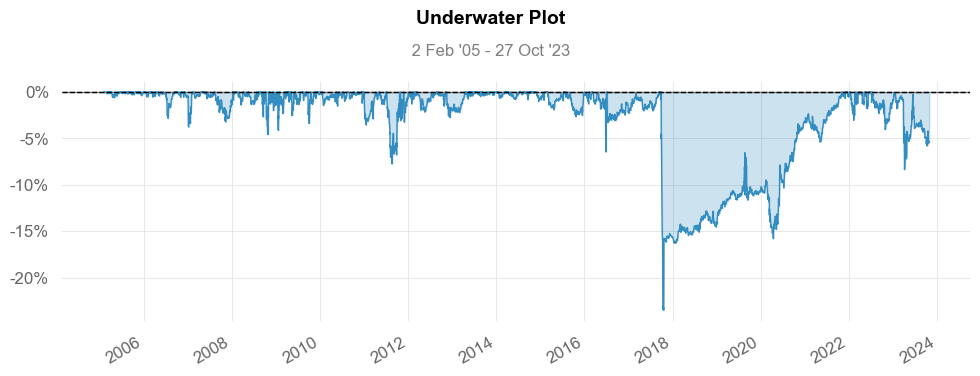

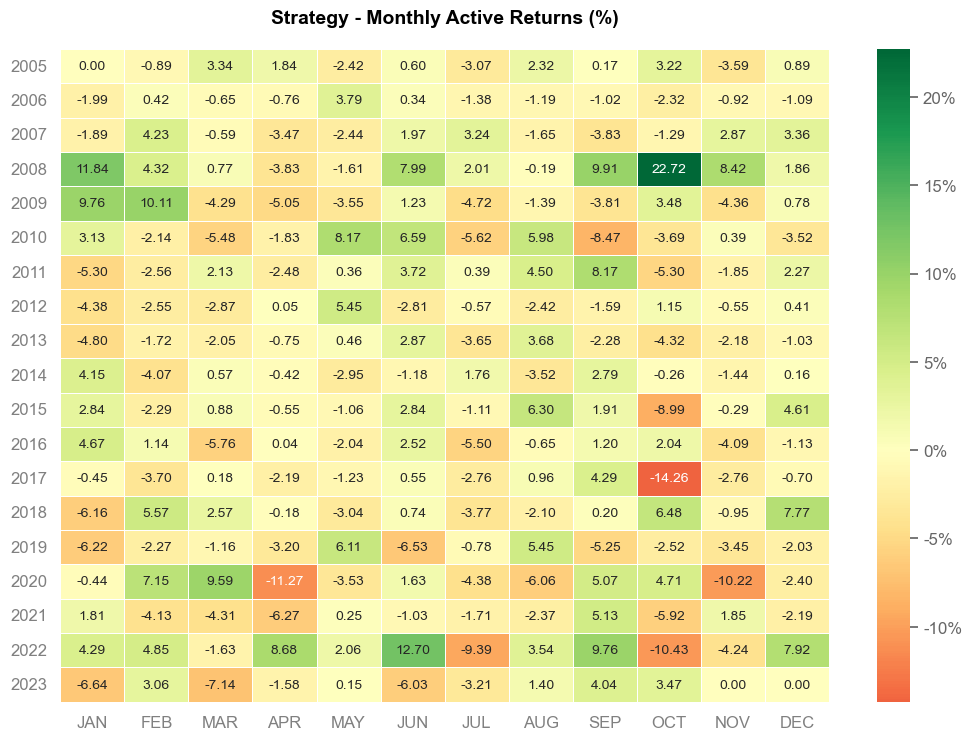

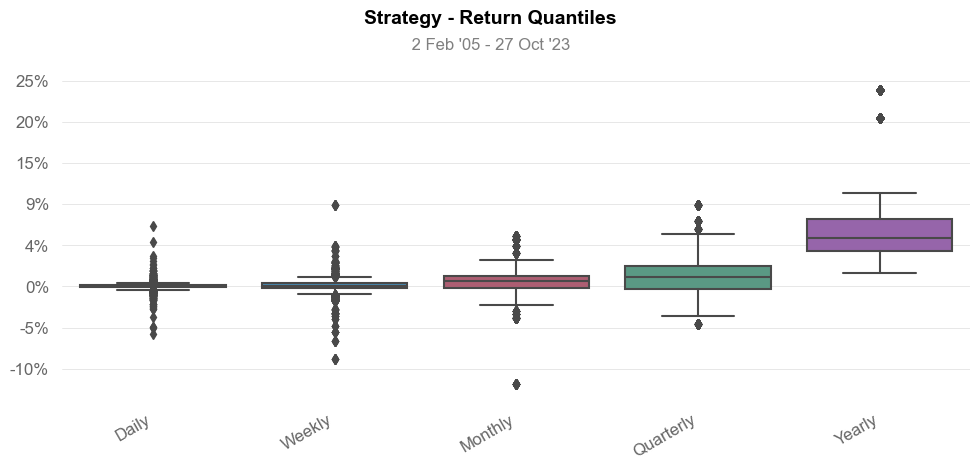

In [151]:
qs.reports.full(ewp_return, "SPY", figsize=(10, 5))